<img src = 'logo.png'>

data origin : usi  
ref: [https://www.kaggle.com/lakshmi25npathi/online-retail-dataset]  (https://www.kaggle.com/lakshmi25npathi/online-retail-dataset)  
dataset ref: [https://www.kaggle.com/vijayuv/onlineretail]      
(https://www.kaggle.com/vijayuv/onlineretail)

In [1]:
import pandas as pd
import numpy as np

import datetime as dt

import warnings
warnings.filterwarnings(action='ignore')

import os
import shutil # shutil.rmtree

#-------------------- visualization (edcoding, grid) -----------

import matplotlib.pyplot as plt
import seaborn as sns

#plt.rc('font', family='NanumGothicOTF') # For MacOS
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
# sns.set()


In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel 
from ast import literal_eval # iterable(string) -> object

from numpy.linalg import norm

# ------------- tensorflow & keras -----------------
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation                 #-------------FC
from keras.layers import Conv2D, MaxPooling2D,Flatten      #-------------CNN
from keras.layers import LSTM                              #-------------RNN
from keras.preprocessing.image import ImageDataGenerator   #-------------Augmentation
from keras.preprocessing.image import array_to_img, img_to_array, load_img # ㄴ flow



from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint  #------------ callback

# --------------------- etc. -----------------------
import re
from PIL import Image

# ----------------- fixing seed --------------------
np.random.seed(1024)
tf.random.set_seed(1024)

In [3]:
# -----------Clustering
# from sklearn.datasets import make_blobs # 임의의 점
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score # silhouette_samples는 차트 그리는 용

# -----------preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# ----------PCA
from sklearn.decomposition import PCA

In [4]:
#-------------------- 주피터 , 출력결과 넓이 늘리기 ---------------
from IPython.core.display import display, HTML
display(HTML("<style>.container{width:100% !important;}</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)

# DataLoad

In [5]:
# df = pd.read_csv('./dataset/OnlineRetail.csv', encoding = 'cp949')

df = pd.read_csv('./dataset/OnlineRetail.csv',  encoding= 'unicode_escape')

In [6]:
print(df.shape, df.info())
df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
(541909, 8) None


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# preprocessing
<pre>
InvoiceDate object --> datetime[ns]
InvoiceNo object --> int64
CustomerID drop np.nan,  float --> int64
Country object --> int64, (label encoding)


## lower columns

In [7]:
df.columns = [col.lower() for col in df.columns]

In [8]:
df.head(1)

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom


## dropna & casting

### customerid

In [9]:
# drop na from customerid
idx = df[df['customerid'].isna()].index
df = df.drop(idx, axis = 0)

In [10]:
df['customerid'].isna().sum()

0

In [11]:
df['customerid'] = df['customerid'].astype('int')

### invoicedate

In [12]:
# cast invoicedate
df['invoicedate'] = df['invoicedate'].astype('datetime64')

### country

In [13]:
# drop rows which country is not United Kingdom
df = df[df['country'] == 'United Kingdom']

In [14]:
df = df.drop('country', axis = 1)

### invoiceno

In [15]:
# invoiceno = df['invoiceno']
# error_NO = set(i[0] for i in invoiceno if re.findall('[^0-9]', i))
# print(error_NO)

In [16]:
df['invoiceno']

0         536365
1         536365
2         536365
3         536365
4         536365
           ...  
541889    581585
541890    581586
541891    581586
541892    581586
541893    581586
Name: invoiceno, Length: 361878, dtype: object

In [17]:
df['invoiceno'] = df['invoiceno'].str.extract(r"(\d+)").astype(int) # 숫자 아닌 것만

In [18]:
# # label encoding invoiceno
# le = LabelEncoder()
# df['invoiceno'] = le.fit_transform(df['invoiceno'])

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361878 entries, 0 to 541893
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   invoiceno    361878 non-null  int32         
 1   stockcode    361878 non-null  object        
 2   description  361878 non-null  object        
 3   quantity     361878 non-null  int64         
 4   invoicedate  361878 non-null  datetime64[ns]
 5   unitprice    361878 non-null  float64       
 6   customerid   361878 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(2), int64(1), object(2)
memory usage: 19.3+ MB


## drop outlier

In [20]:
df.describe()

,invoiceno,quantity,unitprice,customerid
count,361878.000000,361878.000000,361878.000000,361878.000000
mean,560631.447435,11.077029,3.256007,15547.871368
std,13166.072218,263.129266,70.654731,1594.402590
min,536365.000000,-80995.000000,0.000000,12346.000000
25%,549169.000000,2.000000,1.250000,14194.000000
50%,561884.000000,4.000000,1.950000,15514.000000
75%,572282.000000,12.000000,3.750000,16931.000000
max,581586.000000,80995.000000,38970.000000,18287.000000


### Quantity : 거래량 (-)인 데이터 삭제

In [21]:
index = df[df['quantity']<0].index
df = df.drop(index, axis = 0)

### UnitPrice : 가격 0인 데이터 삭제

In [22]:
index = df[df['unitprice']<=0].index
df = df.drop(index, axis = 0)

## 가공 후

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354321 entries, 0 to 541893
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   invoiceno    354321 non-null  int32         
 1   stockcode    354321 non-null  object        
 2   description  354321 non-null  object        
 3   quantity     354321 non-null  int64         
 4   invoicedate  354321 non-null  datetime64[ns]
 5   unitprice    354321 non-null  float64       
 6   customerid   354321 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(2), int64(1), object(2)
memory usage: 18.9+ MB


# RFM(Recency, Frequency, Monetary) : 고객 segmentation의 기본
* RFM은 가치있는 고객을 추출해내어 이를 기준으로 고객을 분류할 수 있는 매우 간단하면서도 유용하게 사용될 수 있는 방법으로 알려져 있어 마케팅에서 가장 많이 사용되는 분석기법


* Recency : 최근(invoice date)
* Frequency : 빈도(invoiceno, stockcode) (주문 때마다 어떤 상품이 구매되었는가)
* Monetary : 양(Quantity * unitprice)

## Recency

In [24]:
df['invoicedate'].min(), df['invoicedate'].max()

(Timestamp('2010-12-01 08:26:00'), Timestamp('2011-12-09 12:49:00'))

In [25]:
df['day_diff'] = df['invoicedate'].max() - df['invoicedate']

In [26]:
df['day_diff'] = df['day_diff'].apply(lambda x : x.days +1) # max날짜는 0으로 나오는 게 싫어서 +1

In [27]:
df['day_diff']

0         374
1         374
2         374
3         374
4         374
         ... 
541889      1
541890      1
541891      1
541892      1
541893      1
Name: day_diff, Length: 354321, dtype: int64

In [28]:
df = df.set_index('invoicedate')

In [29]:
df

,invoiceno,stockcode,description,quantity,unitprice,customerid,day_diff
invoicedate,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,374
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850,374
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850,374
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850,374
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850,374
...,...,...,...,...,...,...,...
2011-12-09 12:31:00,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,1.95,15804,1
2011-12-09 12:49:00,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2.95,13113,1
2011-12-09 12:49:00,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,1.25,13113,1


## Frequency

In [30]:
df['invoiceno'].value_counts()

576339    542
579196    533
580727    529
578270    442
573576    435
         ... 
548940      1
562050      1
579015      1
548985      1
559677      1
Name: invoiceno, Length: 16646, dtype: int64

In [31]:
df['stockcode'].value_counts()

85123A    1947
85099B    1464
22423     1426
84879     1333
47566     1307
          ... 
90202B       1
90202C       1
77079        1
90039C       1
23843        1
Name: stockcode, Length: 3645, dtype: int64

In [32]:
df[['invoiceno','stockcode']].value_counts()

invoiceno  stockcode
555524     22698        20
           22697        12
572861     22775         8
578289     23395         7
572344     M             7
                        ..
553520     22751         1
           22750         1
           22636         1
           22631         1
581586     23275         1
Length: 344435, dtype: int64

## Monetary

In [33]:
df['monetary'] = df['quantity']*df['unitprice']

In [34]:
df.head(1)

,invoiceno,stockcode,description,quantity,unitprice,customerid,day_diff,monetary
invoicedate,,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,374,15.3


# user별 RFM 분석

<pre>
user별
R : day_diff의 max
F : user별 invoiceno count
M : monetary sum

## R

In [35]:
R = df.groupby('customerid').max('day_diff')['day_diff']
R.name = 'R'

## F

In [36]:
F = df.groupby('customerid').count()['invoiceno']
F.name = 'F'

## M

In [37]:
M = df.groupby('customerid').sum()['monetary']
M.name = 'M'

## user dataframe

In [38]:
rfm = pd.concat([R, F, M], axis = 1)
# rfm = rfm.reset_index()
rfm.head()

,R,F,M
customerid,,,
12346,326,1,77183.60
12747,369,103,4196.01
12748,374,4595,33719.73
12749,213,199,4090.88
12820,327,59,942.34


## 훨씬 간단

In [39]:
# hjh
# R=pd.DataFrame(df['date_diff'].groupby(df['InvoiceNo']).max())
# F=pd.DataFrame(df['InvoiceNo'].groupby(df['InvoiceNo']).count())
# M=pd.DataFrame(df['monetary'].groupby(df['InvoiceNo']).sum())
# RFM=pd.concat([R,F,M],axis=1)
# RFM.columns=['Recency','Frequency','Monetary']

In [40]:
# kms
df.groupby('customerid').agg({'day_diff': 'max', 'customerid': 'count', 'monetary': 'sum'}).head(1)

,day_diff,customerid,monetary
customerid,,,
12346,326,1,77183.6


# rfm의 목적 : 휴면고객과 이탈고객 충성고객(VVIP) 구분(VVIP 챙기는 건 너무 당연)
* 휴면고객 (== 이탈고객?): 마지막으로 구매한지 오래 됐지만 돈 많이 썼던 고객

* Kmeans(), scatter(), silhoutte_score

In [41]:
rfm.describe()

,R,F,M
count,3920.000000,3920.000000,3920.000000
mean,223.553571,90.388010,1864.385601
std,118.070706,217.808385,7482.817477
min,1.000000,1.000000,3.750000
25%,112.000000,17.000000,300.280000
50%,249.000000,41.000000,652.280000
75%,327.000000,99.250000,1576.585000
max,374.000000,7847.000000,259657.300000


In [42]:
# sil_score=silhouette_score(rfm[['R', 'F', 'M']], labels=rfm['cluster_label'], metric='euclidean', random_state=1024)

# 검증 & 시각화
* 엘보차트 __ n_cluster
* PCA - 2차 차원축소(시각화하려면 필요)
* scatter 군집 시각화

In [50]:
import math

In [51]:
def pca_KMEANS(X, cluster_list=[2,3,4,5,6], elbow=True):
    pca = PCA(n_components=2, random_state=1024) # n_components : 축소된 차원 차수
    pca_X=pca.fit_transform(X)
    print('**'*40)
    print('PCA ratio: ',pca.explained_variance_ratio_)
    print('sum of PCA ratio: ', pca.explained_variance_ratio_.sum())
    print('**'*40)

    inertia_list = []
    
    sub_row = 2
    sub_col = math.ceil((len(cluster_list)+1)/2)
    
    f, axes = plt.subplots(sub_row,sub_col, figsize = (20,6))

    for i, k in enumerate(cluster_list):
        row = i//3
        col = i%3

        model = KMeans(n_clusters = k, random_state = 1024)
        model.fit(pca_X)
        cluster_label = model.predict(pca_X) # cluster_label
        
        inertia_list.append(model.inertia_)
        print(f"n_components : {k}")
        print(f"SCORE : {silhouette_score(pca_X, cluster_label)}")
        print(f"INERTIA_ : {model.inertia_}")
        print('--'*30)
        sns.scatterplot(x=pca_X[:,0], y=pca_X[:,1], hue=cluster_label, ax=axes[row, col])
    
    if elbow ==True:
        sns.lineplot(cluster_list, inertia_list, ax=axes[1,2])
        plt.xlabel("K cluster count")
        plt.ylabel("sum of squared distances")
        plt.show()
    
    return pred

## 원본

********************************************************************************
PCA ratio:  [9.99002170e-01 7.63980924e-04]
sum of PCA ratio:  0.9997661510984039
********************************************************************************
n_components : 2
SCORE : 0.9747982262815946
INERTIA_ : 91302336280.59332
------------------------------------------------------------
n_components : 3
SCORE : 0.9579579970549881
INERTIA_ : 30888347946.74387
------------------------------------------------------------
n_components : 4
SCORE : 0.841092912941218
INERTIA_ : 19377573902.09444
------------------------------------------------------------
n_components : 5
SCORE : 0.8119478446326409
INERTIA_ : 13109012914.296692
------------------------------------------------------------
n_components : 6
SCORE : 0.8118527124362432
INERTIA_ : 9037802672.862974
------------------------------------------------------------


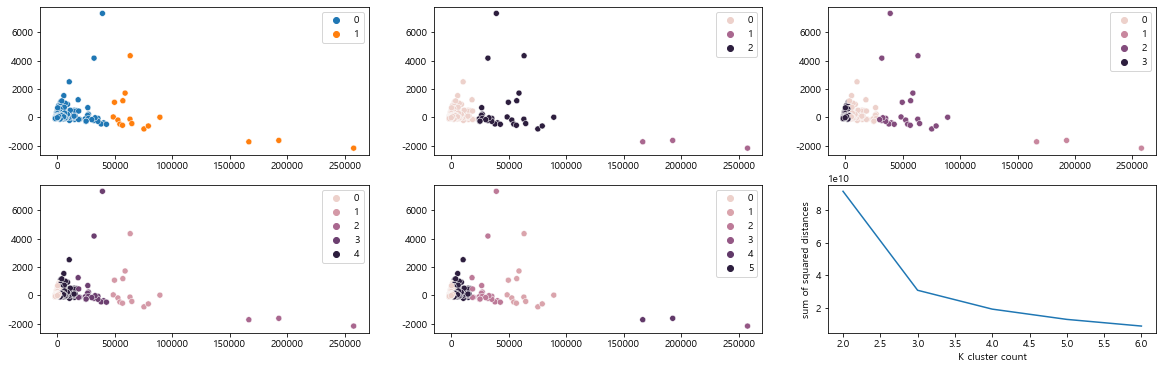

In [52]:
pca_KMEANS(rfm)

## Standard Scaler

In [45]:
ss = StandardScaler()
rfm_array = ss.fit_transform(rfm)
# rfm = pd.DataFrame(rfm_array, columns = rfm.columns, index = rfm.index)

********************************************************************************
PCA ratio:  [0.48810717 0.28907626]
sum of PCA ratio:  0.7771834298703479
********************************************************************************
n_components : 2
SCORE : 0.5303293896441683
INERTIA_ : 5911.414731762385
------------------------------------------------------------
n_components : 3
SCORE : 0.5530203509165856
INERTIA_ : 2903.075261430877
------------------------------------------------------------
n_components : 4
SCORE : 0.5786742756181078
INERTIA_ : 1942.671358673179
------------------------------------------------------------
n_components : 5
SCORE : 0.4912809802169425
INERTIA_ : 1455.297717426337
------------------------------------------------------------
n_components : 6
SCORE : 0.5004473256372568
INERTIA_ : 1035.4013275735203
------------------------------------------------------------


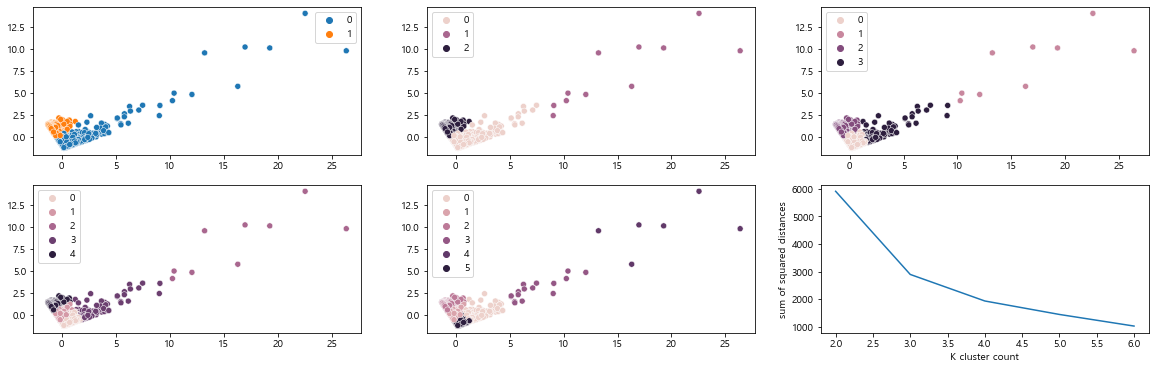

In [46]:
pca_KMEANS(rfm_array)

## log

********************************************************************************
PCA ratio:  [0.73305423 0.17255305]
sum of PCA ratio:  0.905607281949705
********************************************************************************
n_components : 2
SCORE : 0.45478916360994004
INERTIA_ : 6486.901723415905
------------------------------------------------------------
n_components : 3
SCORE : 0.37083984943066384
INERTIA_ : 4695.552653953614
------------------------------------------------------------
n_components : 4
SCORE : 0.406080715251612
INERTIA_ : 3337.089973471805
------------------------------------------------------------
n_components : 5
SCORE : 0.38186257609269847
INERTIA_ : 2683.9982152616462
------------------------------------------------------------
n_components : 6
SCORE : 0.3922927018112364
INERTIA_ : 2249.90814704651
------------------------------------------------------------


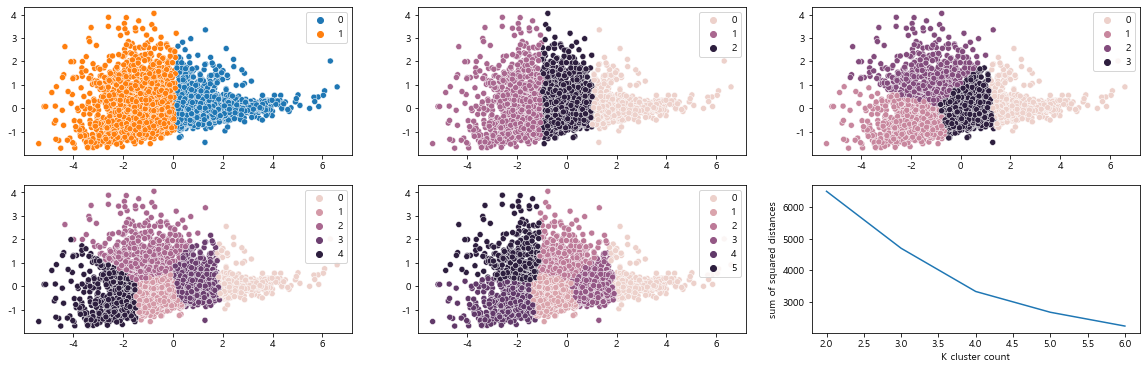

In [47]:
log_rfm = rfm.copy()
log_rfm['R'] = np.log1p(rfm['R'])
log_rfm['F'] = np.log1p(rfm['F'])
log_rfm['M'] = np.log1p(rfm['M'])

ss.fit_transform(log_rfm)

pca_KMEANS(log_rfm)

# 고객유형분석
* LogScaler - 군집
* n_cluster : 4

-> 각 군집의 R,F,M 평균 구해서 각 군집 당 차이 확인

In [ ]:
log_rfm = rfm.copy()
log_rfm['R'] = np.log1p(rfm['R'])
log_rfm['F'] = np.log1p(rfm['F'])
log_rfm['M'] = np.log1p(rfm['M'])

rfm_log_scaler = ss.fit_transform(log_rfm)
pca_KMEANS()



In [126]:
log_rfm = rfm.copy()
log_rfm['R'] = np.log1p(rfm['R'])
log_rfm['F'] = np.log1p(rfm['F'])
log_rfm['M'] = np.log1p(rfm['M'])
rfm_log_scaler = ss.fit_transform(log_rfm)

temp = pd.DataFrame(data=rfm_log_scaler, index=rfm.index)
temp.head()


pca = PCA(n_components=2) # n_components : 축소된 차원 차수
pca_X=pca.fit_transform(temp)

model = KMeans(n_clusters = 4, random_state = 1024)
model.fit(pca_X)
pred = model.predict(pca_X) # cluster_label
temp.columns = ['R', 'F', 'M']

log_rfm['cluster_label'] = pred.reshape(-1,1)
temp['cluster_label'] = pred.reshape(-1,1)


In [63]:
temp.head()

,R,F,M,cluster_label
customerid,,,,
12346,0.720669,-2.403387,3.785914,1
12747,0.860671,0.732578,1.444280,0
12748,0.875883,3.739419,3.119983,0
12749,0.240200,1.251577,1.423880,0
12820,0.724130,0.296025,0.243880,1


In [122]:
rfm_label = rfm.copy()
rfm_label['cluster_label'] = temp['cluster_label']

rfm_label['mon_per_frq'] = rfm_label['M'] / rfm_label['F']

res = rfm_label.groupby(by = 'cluster_label').agg({'R':'mean', 'F':'mean', 'M':'mean', 'mon_per_frq':'mean'})
res
# temp.groupby(by = 'cluster_label').agg({'R':'std', 'F':'std', 'M':'std'})

# 3번이 불량 고객

,R,F,M,mon_per_frq
cluster_label,,,,
0,308.688889,264.461111,5908.270590,96.740690
1,260.090841,58.229337,1035.420783,94.733688
2,46.227913,35.025608,477.403382,30.951218
3,237.839286,11.996652,253.935123,47.796593


In [72]:
# idx0 = temp[temp['cluster_label']==0].index
# idx1 = temp[temp['cluster_label']==1].index
# idx2 = temp[temp['cluster_label']==2].index
# idx3 = temp[temp['cluster_label']==3].index

# rfm.loc[idx0, 'cluster_label'] = 0
# rfm.loc[idx1, 'cluster_label'] = 1
# rfm.loc[idx2, 'cluster_label'] = 2
# rfm.loc[idx3, 'cluster_label'] = 3



In [110]:
# 정말 불량고객인지 확인
# df = df.reset_index()
# df = df.set_index('customerid')

# idx = rfm_label[rfm_label['cluster_label'] == 3].index
# df.loc[idx, :]

# df = df.reset_index()
# df = df.set_index('invoicedate')


# 더 간단
df['cluster_label'] =0

idx = rfm_label[rfm_label['cluster_label'] == 1].index
df['cluster_label'][df['customerid'].isin(idx)] = 1

idx = rfm_label[rfm_label['cluster_label'] == 2].index
df['cluster_label'][df['customerid'].isin(idx)] = 2

idx = rfm_label[rfm_label['cluster_label'] == 3].index
df['cluster_label'][df['customerid'].isin(idx)] = 3


In [116]:
df

,customerid,invoiceno,stockcode,description,quantity,unitprice,day_diff,monetary,cluster_label
invoicedate,,,,,,,,,
2010-12-01 08:26:00,17850,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,374,15.30,0
2010-12-01 08:26:00,17850,536365,71053,WHITE METAL LANTERN,6,3.39,374,20.34,0
2010-12-01 08:26:00,17850,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,374,22.00,0
2010-12-01 08:26:00,17850,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,374,20.34,0
2010-12-01 08:26:00,17850,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,374,20.34,0
...,...,...,...,...,...,...,...,...,...
2011-12-09 12:31:00,15804,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,1.95,1,23.40,0
2011-12-09 12:49:00,13113,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2.95,1,23.60,0
2011-12-09 12:49:00,13113,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,1.25,1,30.00,0


In [120]:
df['mon_per_day'] = df['monetary'] / df['day_diff']

In [121]:
df.groupby('cluster_label').agg({'mon_per_day' : 'mean'})

,mon_per_day
cluster_label,
0,1.325611
1,0.355027
2,0.908713
3,0.197322


In [ ]:
df['mon_per_frq'] = df['monetary'] / df['day_diff']

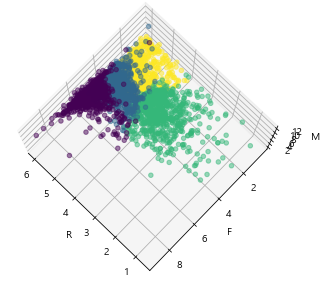

In [151]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure( figsize=(4,4))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=80, azim=134) # 48, 134
ax.scatter(log_rfm['R'],log_rfm['F'],log_rfm['M'],c=log_rfm['cluster_label'],alpha=0.5) # label은 다시 fit predict 해야됨
ax.set_xlabel('R')
ax.set_ylabel('F')
ax.set_zlabel('M')
plt.show()